# 1) Titanic Assignment

### 1.1) Import

In [245]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from statistics import mode

from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

#Reset some default parameters.
warnings.filterwarnings('ignore')
sns.set(style="white")
fs = 20.
RS = 1234126
#https://stackabuse.com/understanding-roc-curves-with-python/

### 1.2) Retrieve and Process data

In [281]:
fpath_train = os.path.join('./data', 'train.csv')
fpath_test = os.path.join('./data', 'test.csv')
df_train = pd.read_csv(fpath_train)
df_test = pd.read_csv(fpath_test)

#Accordint to https://www.kaggle.com/c/titanic/discussion/2881
#SibSp: Number of siblings/Spouses onboard.
#Parch: Number of parents/children onboard.

In [282]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [283]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [284]:
#Although some columns may actually hold useful information, for the purpose of this assignment I will
#discard some of the data that requires too many transformations. E.g.: the Name column holds the person's
#title, which is significant in training the model.

#Clean the train data.
cols = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
df_train = df_train[cols]
print(df_train.shape)
print(df_train.isna().sum())

#Most nan are in age. Replace them with the mean age.
#Replace nan in embarked with the most common port.
df_train['Age'].fillna((df_train['Age'].mean()), inplace=True)
df_train['Embarked'].fillna((mode(df_train['Embarked'].values)), inplace=True)

(891, 8)
Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


In [285]:
#Clean the test data.
cols = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
df_test = df_test[cols]
print(df_test.shape)
print(df_test.isna().sum())

#Most nan are in age. Replace them with the mean age.
#Same fot the fare.
df_test['Age'].fillna((df_test['Age'].mean()), inplace=True)
df_test['Fare'].fillna((mode(df_test['Fare'].values)), inplace=True)

(418, 7)
Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64


In [286]:
#Encode categorical variables.
#How to ensure that the hotEnconding is the same for the train and test data?
cols = ['Sex', 'Embarked']
le = LabelEncoder()
df_train[cols] = df_train[cols].apply(le.fit_transform)
df_test[cols] = df_test[cols].apply(le.fit_transform)

df_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,1
1,3,0,47.0,1,0,7.0000,2
2,2,1,62.0,0,0,9.6875,1
3,3,1,27.0,0,0,8.6625,2
4,3,0,22.0,1,1,12.2875,2


In [287]:
X = df_train.iloc[:,1:]
y = df_train.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RS)

In [288]:
#Standardize the data.
sc = StandardScaler()
sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled= sc.transform(X_test)
df_train_scaled.head()

,0,1,2,3,4,5,6
0,0.827377,0.737695,-0.592481,0.432793,-0.473674,-0.502445,0.585954
1,-1.566107,-1.355574,0.638789,0.432793,-0.473674,0.786845,-1.942303
2,0.827377,-1.355574,-0.284663,-0.474545,-0.473674,-0.488854,0.585954
3,-1.566107,-1.355574,0.407926,0.432793,-0.473674,0.420730,0.585954
4,0.827377,0.737695,0.407926,-0.474545,-0.473674,-0.486337,0.585954


### 1.3) Train Model

In [289]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

#make predictions.
y_pred = rfc.predict(X_test)
rf_probs = rfc.predict_proba(X_test) #Probabilities for not survived/survived
rf_probs_surv = rf_probs[:,1] #Probabilities for Survived.

print('Model accuracy is {}'.format(accuracy_score(y_test, y_pred)))
print('ROC AUC score is {}'.format(roc_auc_score(y_test, rf_probs_surv)))

Model accuracy is 0.8212290502793296
ROC AUC score is 0.8739130434782609


Text(0, 0.5, 'True Positive Rate')

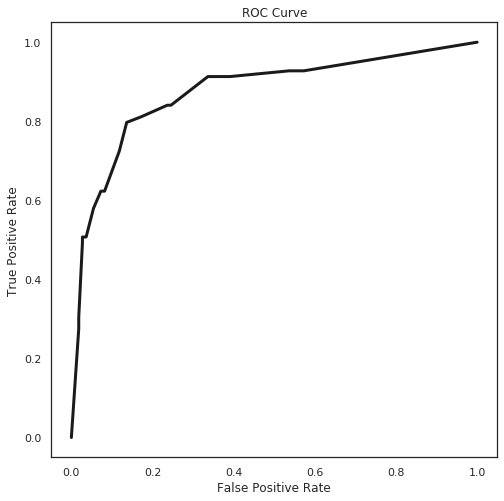

In [290]:
#Compute and plot roc curve.

rf_fpr, rf_tpr, aux = roc_curve(y_test, rf_probs_surv)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(rf_fpr, rf_tpr, ls='-', marker='None', lw=3., color='k')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')


##### 1.3.1) Partial Conclusions

+ Metrics for this unrefined Random Forest model:
  + Model accuracy (% of correct results): ~0.80
  + AUC score (area under the ROC curve): ~0.84
+ The ROC curve exhibits the rate of true positives vs false positives. Each point in the curve corresponds to a different threshold of what probabbility is required for a prodiction to be considered true. A high threshold leads to a low rate of false positive, but at the expense of missing many true positives.

### 1.4) Parameter Search

##### 1.4.1) n_estimators

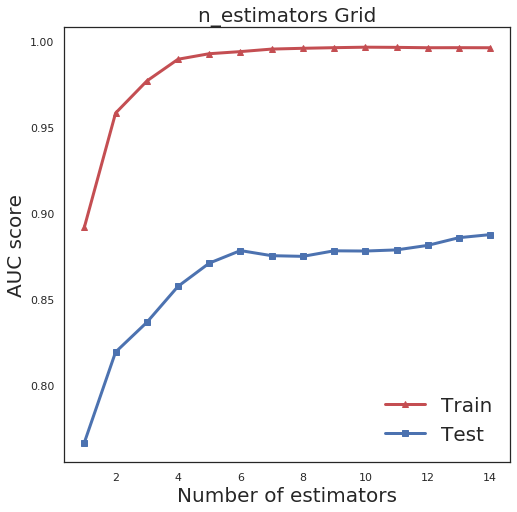

In [291]:
#Investigate the n_estimator parameter.

n_estimators = range(1,15)
auc_test, auc_train = [], []

fig, ax = plt.subplots(figsize=(8,8))
for n_est in n_estimators:
   
    rfc = RandomForestClassifier(n_estimators=n_est, random_state=RS)
    rfc.fit(X_train,y_train)

    rf_train_probs_surv = rfc.predict_proba(X_train)[:,1] #Probabilities for Survived for the train set.
    rf_test_probs_surv = rfc.predict_proba(X_test)[:,1] #Probabilities for Survived for the test set.
    
    auc_train.append(roc_auc_score(y_train, rf_train_probs_surv))
    auc_test.append(roc_auc_score(y_test, rf_test_probs_surv))

    
ax.plot(n_estimators, auc_train, ls='-', marker='^', lw=3., color='r', label='Train')
ax.plot(n_estimators, auc_test, ls='-', marker='s', lw=3., color='b', label='Test')
ax.set_title('n_estimators Grid', fontsize=fs)
ax.set_xlabel('Number of estimators', fontsize=fs)
ax.set_ylabel('AUC score', fontsize=fs)
ax.legend(frameon=False, loc=4, numpoints=1, fontsize=fs)


##### 1.4.2) max_depth

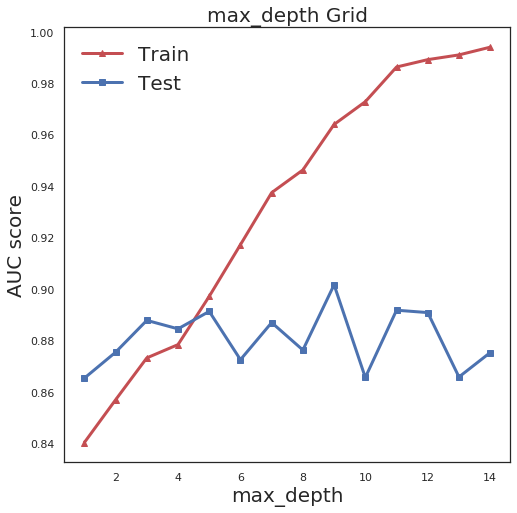

In [257]:
#Investigate the max_depth parameter.

max_depth = range(1,15)
auc_test, auc_train = [], []

fig, ax = plt.subplots(figsize=(8,8))
for md in max_depth:
   
    rfc = RandomForestClassifier(max_depth=md, random_state=RS)
    rfc.fit(X_train,y_train)

    rf_train_probs_surv = rfc.predict_proba(X_train)[:,1] #Probabilities for Survived for the train set.
    rf_test_probs_surv = rfc.predict_proba(X_test)[:,1] #Probabilities for Survived for the test set.
    
    auc_train.append(roc_auc_score(y_train, rf_train_probs_surv))
    auc_test.append(roc_auc_score(y_test, rf_test_probs_surv))

    
ax.plot(max_depth, auc_train, ls='-', marker='^', lw=3., color='r', label='Train')
ax.plot(max_depth, auc_test, ls='-', marker='s', lw=3., color='b', label='Test')
ax.set_title('max_depth Grid', fontsize=fs)
ax.set_xlabel('max_depth', fontsize=fs)
ax.set_ylabel('AUC score', fontsize=fs)
ax.legend(frameon=False, loc=2, numpoints=1, fontsize=fs)

##### 1.4.3) min_samples_split

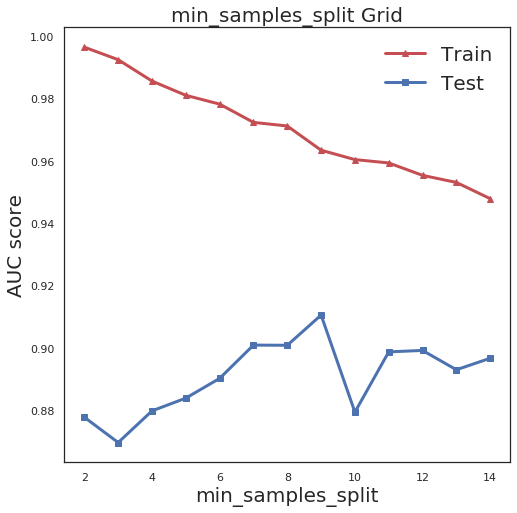

In [258]:
#Investigate the min_samples_split parameter.

min_samples = range(2,15)
auc_test, auc_train = [], []

fig, ax = plt.subplots(figsize=(8,8))
for mss in min_samples:
   
    rfc = RandomForestClassifier(min_samples_split=mss, random_state=RS)
    rfc.fit(X_train,y_train)

    rf_train_probs_surv = rfc.predict_proba(X_train)[:,1] #Probabilities for Survived for the train set.
    rf_test_probs_surv = rfc.predict_proba(X_test)[:,1] #Probabilities for Survived for the test set.
    
    auc_train.append(roc_auc_score(y_train, rf_train_probs_surv))
    auc_test.append(roc_auc_score(y_test, rf_test_probs_surv))

    
ax.plot(min_samples, auc_train, ls='-', marker='^', lw=3., color='r', label='Train')
ax.plot(min_samples, auc_test, ls='-', marker='s', lw=3., color='b', label='Test')
ax.set_title('min_samples_split Grid', fontsize=fs)
ax.set_xlabel('min_samples_split', fontsize=fs)
ax.set_ylabel('AUC score', fontsize=fs)
ax.legend(frameon=False, loc=1, numpoints=1, fontsize=fs)


##### 1.4.4) min_samples_leaf

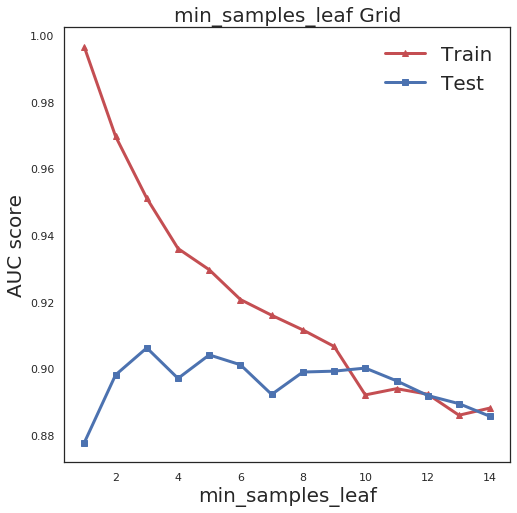

In [259]:
#Investigate the min_samples_leaf parameter.

min_samples = range(1,15)
auc_test, auc_train = [], []

fig, ax = plt.subplots(figsize=(8,8))
for msl in min_samples:
   
    rfc = RandomForestClassifier(min_samples_leaf=msl, random_state=RS)
    rfc.fit(X_train,y_train)

    rf_train_probs_surv = rfc.predict_proba(X_train)[:,1] #Probabilities for Survived for the train set.
    rf_test_probs_surv = rfc.predict_proba(X_test)[:,1] #Probabilities for Survived for the test set.
    
    auc_train.append(roc_auc_score(y_train, rf_train_probs_surv))
    auc_test.append(roc_auc_score(y_test, rf_test_probs_surv))
    
ax.plot(min_samples, auc_train, ls='-', marker='^', lw=3., color='r', label='Train')
ax.plot(min_samples, auc_test, ls='-', marker='s', lw=3., color='b', label='Test')
ax.set_title('min_samples_leaf Grid', fontsize=fs)
ax.set_xlabel('min_samples_leaf', fontsize=fs)
ax.set_ylabel('AUC score', fontsize=fs)
ax.legend(frameon=False, loc=1, numpoints=1, fontsize=fs)

##### 1.4.5) max_features

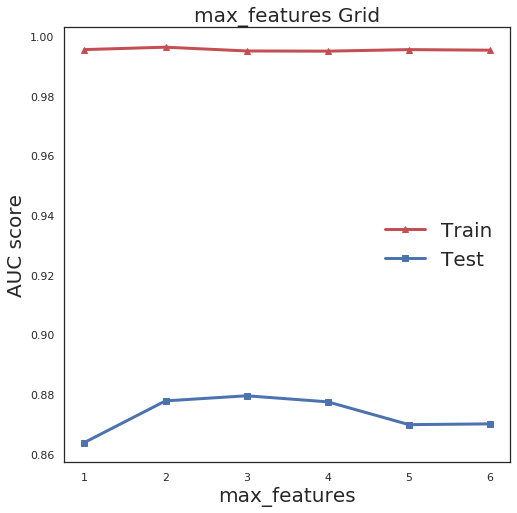

In [292]:
#Investigate the max_features parameter.

max_features = list(range(1,X_train.shape[1]))
auc_test, auc_train = [], []

fig, ax = plt.subplots(figsize=(8,8))
for mf in max_features:
   
    rfc = RandomForestClassifier(max_features=mf, random_state=RS)
    rfc.fit(X_train,y_train)

    rf_train_probs_surv = rfc.predict_proba(X_train)[:,1] #Probabilities for Survived for the train set.
    rf_test_probs_surv = rfc.predict_proba(X_test)[:,1] #Probabilities for Survived for the test set.
    
    auc_train.append(roc_auc_score(y_train, rf_train_probs_surv))
    auc_test.append(roc_auc_score(y_test, rf_test_probs_surv))
    
ax.plot(max_features, auc_train, ls='-', marker='^', lw=3., color='r', label='Train')
ax.plot(max_features, auc_test, ls='-', marker='s', lw=3., color='b', label='Test')
ax.set_title('max_features Grid', fontsize=fs)
ax.set_xlabel('max_features', fontsize=fs)
ax.set_ylabel('AUC score', fontsize=fs)
ax.legend(frameon=False, loc='best', numpoints=1, fontsize=fs)

##### 1.4.7) Best Model via Independent search

In [293]:
rfc = RandomForestClassifier(n_estimators=6,
                             max_depth=4,
                             min_samples_split=9,
                             min_samples_leaf=3,
                             max_features=3,
                             random_state=RS)
rfc.fit(X_train,y_train)

y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)
rf_train_probs_surv = rfc.predict_proba(X_train)[:,1] #Probabilities for Survived for the train set.
rf_test_probs_surv = rfc.predict_proba(X_test)[:,1] #Probabilities for Survived for the test set.

print('Test sample:')
print('    Model accuracy is {}'.format(accuracy_score(y_test, y_test_pred)))
print('    ROC AUC score is {}'.format(roc_auc_score(y_test, rf_test_probs_surv)))

print('Train sample:')
print('    Model accuracy is {}'.format(accuracy_score(y_train, y_train_pred)))
print('    ROC AUC score is {}'.format(roc_auc_score(y_train, rf_train_probs_surv)))

Test sample:
    Model accuracy is 0.7988826815642458
    ROC AUC score is 0.8776679841897234
Train sample:
    Model accuracy is 0.8342696629213483
    ROC AUC score is 0.8826003154021378


##### 1.4.8) Best Model via gird search

In [262]:
#Set the search grid and scores to be used.
random_grid = {'n_estimators': range(5,12),
               'max_depth': range(3,10),
               'min_samples_split': range(7,15),
               'min_samples_leaf': range(1,6),
               'max_features': range(1,X_train.shape[1])}
scores = ['roc_auc']
cross_val = 5

In [263]:
#Run the parameter optmization.
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    rfc = GridSearchCV(RandomForestClassifier(),
                       random_grid,
                       cv=cross_val,
                       scoring=score)
    rfc.fit(X_train,y_train)
    print('    Best parameters:', rfc.best_params_)
    print('')
    y_true, y_pred = y_test, rfc.predict(X_test)
    print(classification_report(y_true, y_pred))

# Tuning hyper-parameters for roc_auc

    Best parameters: {'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 11, 'n_estimators': 5}

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       110
           1       0.84      0.61      0.71        69

    accuracy                           0.80       179
   macro avg       0.82      0.77      0.78       179
weighted avg       0.81      0.80      0.80       179



In [294]:
# Cmpute AUC score with the best parameters from the grid search.

rfc = RandomForestClassifier(n_estimators=5,
                             max_depth=8,
                             min_samples_split=11,
                             min_samples_leaf=3,
                             max_features=3)
rfc.fit(X_train,y_train)

y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)
rf_train_probs_surv = rfc.predict_proba(X_train)[:,1] #Probabilities for Survived for the train set.
rf_test_probs_surv = rfc.predict_proba(X_test)[:,1] #Probabilities for Survived for the test set.

print('Test sample:')
print('    Model accuracy is {}'.format(accuracy_score(y_test, y_test_pred)))
print('    ROC AUC score is {}'.format(roc_auc_score(y_test, rf_test_probs_surv)))

print('Train sample:')
print('    Model accuracy is {}'.format(accuracy_score(y_train, y_train_pred)))
print('    ROC AUC score is {}'.format(roc_auc_score(y_train, rf_train_probs_surv)))


Test sample:
    Model accuracy is 0.8156424581005587
    ROC AUC score is 0.8961791831357049
Train sample:
    Model accuracy is 0.8553370786516854
    ROC AUC score is 0.9158552153996347


##### 1.4.9) Conclusions

+ n_estimators:
  + 6 seems to be an optimal choice of number of estimators. It delivers a high AUC score, and higher numbers lead to only marginal improvement.
+ max_depth:
  + As expected, the higher the max depth, the higher the accuracy on predicting the train set itself. This indicates over-fitting for high max_depth. 
  + A max_depth of 3 and 4 delivers a high AUC score for the test data, while not over-fitting.
+ min_samples_split:
  + Adopting min_samples_split=9 provides the highest AUC score.
+ min_samples_leaf:
  + Adopting min_samples_leaf=3 provides the highest AUC score.
+ max_features:
  + 2 max_features maximized the AUC score for the test sample.
+ Best model via independent seach:
  + From the test sample, one gets an accuracy score of 0.80 and an AUC score of 0.88.
+ Best model via GridSearch:
  + From the test sample, one gets an accuracy score of 0.81 and an AUC score of 0.91.
+ Naturally, the grid search will produce better results, but at the expensive of high computing power. In this example, I would say that the improvement of a few percent is not necessarily relevant compared with searching best parameters one at a time.

| Parameter | Ind. Search | Grid Search |
| ------:| -----------:| -----------:|
| n_estimators | 6 | 9 |
| max_depth | 4 | 6 |
| min_samples_split | 9 | 9 |
| min_samples_leaf | 3 | 1 |
| max_features | 3 | 2 |
| Accuracy | 0.80 | 0.81  |
| AUC ROC score | 0.87 | 0.90 | 


# 2) SVM Assignment

### 2.1) Retrieve and Process data

In [265]:
#Load the iris dataset.
iris = datasets.load_iris() 

data = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['Species'])
data['Species'] = data['Species'].map({0.0: 'setosa',  1.0: 'versicolor', 
                                      2.0: 'virginic'})

In [266]:
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [267]:
#Split the data into train and test
X = iris.data
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RS)

In [268]:
#Standardized the data
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

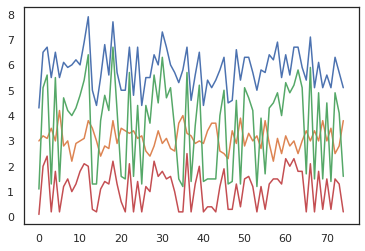

In [269]:
plt.plot(X_train)

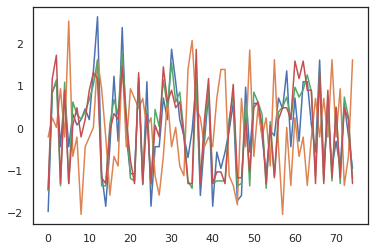

In [270]:
plt.plot(X_train_std)

### 2.2) Q: Why is it important to scale the inputs when using SVMs?

In [271]:
#Using non-scaled data.
svm_model = svm.SVC(kernel='rbf')

svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print('Model accuracy is {}'.format(accuracy_score(y_test, y_pred)))

Model accuracy is 0.9466666666666667


In [272]:
#Using scaled data.
svm_model = svm.SVC(kernel='rbf')

svm_model.fit(X_train_std, y_train)
y_pred = svm_model.predict(X_test_std)
print('Model accuracy is {}'.format(accuracy_score(y_test, y_pred)))

Model accuracy is 0.9333333333333333


##### 2.2) A: Although the example above does not support this conclusion, SVM relies on the distance between data points separated by hyperplanes. In order to properly compare such distances, the 'order of magnitude' of the axes in tihs hyperspace must be comparable. Otherwise, one or more axes may bias the result by being weighted more significantly. 

### 2.3) Q: How can an SVM classifier output a confidence score when it classifies an instance?

In [273]:
#Use probability = True
svm_model = svm.SVC(kernel='rbf', probability=True)

svm_model.fit(X_train_std, y_train)
y_pred = svm_model.predict(X_test_std)
y_decfun = svm_model.decision_function(X_test_std)
y_prob = svm_model.predict_proba(X_test_std)

print('Model accuracy is {}'.format(accuracy_score(y_test, y_pred)))
print(y_decfun[0:5])
print(y_prob[0:5])

Model accuracy is 0.9333333333333333
[[ 2.22431372  0.87300209 -0.19683662]
 [-0.21394946  0.85453439  2.2398687 ]
 [ 2.22593318  0.87824729 -0.20148797]
 [ 2.22785811  0.86187621 -0.19743052]
 [-0.22801469  1.09256639  2.21345227]]
[[0.9327218  0.04036534 0.02691285]
 [0.01747124 0.00596917 0.97655958]
 [0.94005017 0.03515258 0.02479725]
 [0.9429057  0.03180925 0.02528504]
 [0.01475059 0.06482932 0.92042009]]


##### 2.3) A: If probability=False, a pseudo probability can be estimated based on the distance to the hyperplanes. These are retrieved with via the decision_function class function. Conversely, one may set probability=True, in which case the 'classification confidence' is estimated using not only the SVM scores but also via cross-validation of the data. See Sec. 1.4.1.2 of the [SVM documentation](https://scikit-learn.org/stable/modules/svm.html).

### 2.4) Q: If you train an SVM classifier with an RBF Kernel and you find out that it underfits the training set. Should you increase/ decrease the gamma? What about C?

Best gamma is 0.046415888336127774


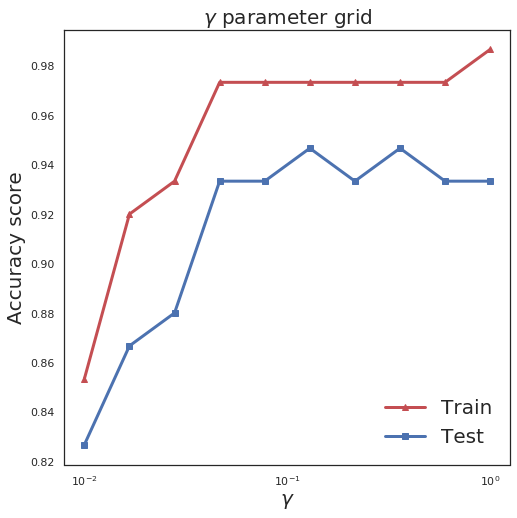

In [274]:
fig, ax = plt.subplots(figsize=(8,8))
gamma_test = np.logspace(-2, 0., 10)
accuracy_test, accuracy_train = [], []
for gamma in gamma_test:
   
    svm_model = svm.SVC(kernel='rbf', gamma=gamma, random_state=RS)
    svm_model.fit(X_train_std,y_train)
    
    y_pred_train = svm_model.predict(X_train_std)
    y_pred_test = svm_model.predict(X_test_std)

    accuracy_train.append(accuracy_score(y_train, y_pred_train))
    accuracy_test.append(accuracy_score(y_test, y_pred_test))
    
ax.plot(gamma_test, accuracy_train, ls='-', marker='^', lw=3., color='r', label='Train')
ax.plot(gamma_test, accuracy_test, ls='-', marker='s', lw=3., color='b', label='Test')
ax.set_title(r'$\gamma$ parameter grid', fontsize=fs)
ax.set_xlabel(r'$\gamma$', fontsize=fs)
ax.set_ylabel('Accuracy score', fontsize=fs)
ax.set_xscale('log')
ax.legend(frameon=False, loc=4, numpoints=1, fontsize=fs)
print('Best gamma is {}'.format(gamma_test[3]))

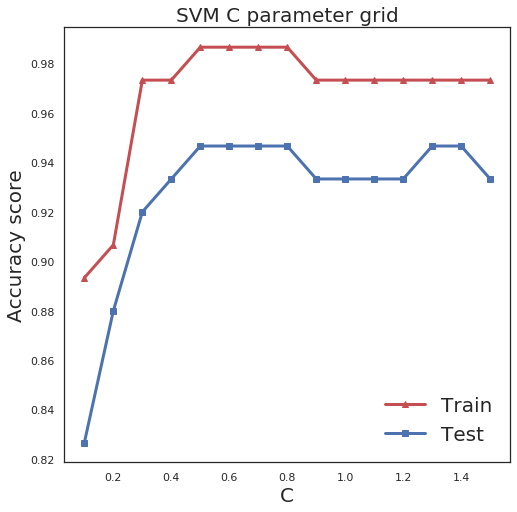

In [275]:
fig, ax = plt.subplots(figsize=(8,8))
C_test = np.arange(0.1, 1.51, 0.1)
accuracy_test, accuracy_train = [], []
for C in C_test:
   
    svm_model = svm.SVC(kernel='rbf', C=C)
    svm_model.fit(X_train_std,y_train)
    
    y_pred_train = svm_model.predict(X_train_std)
    y_pred_test = svm_model.predict(X_test_std)

    accuracy_train.append(accuracy_score(y_train, y_pred_train))
    accuracy_test.append(accuracy_score(y_test, y_pred_test))
    
ax.plot(C_test, accuracy_train, ls='-', marker='^', lw=3., color='r', label='Train')
ax.plot(C_test, accuracy_test, ls='-', marker='s', lw=3., color='b', label='Test')
ax.set_title('SVM C parameter grid', fontsize=fs)
ax.set_xlabel('C', fontsize=fs)
ax.set_ylabel('Accuracy score', fontsize=fs)
ax.legend(frameon=False, loc=4, numpoints=1, fontsize=fs)

##### 2.4) A: If the model is underfitting the data, then one should increase gamma. A gamma value close to one will lead to over-fitting. [Source](https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python). The C parameter controls the margin of the dividing hyperplane. A low C value will underfit the data.

### 2.5) Q: How can you train a SVM regressor on a sample data?

In [276]:
svr_model = svm.SVR(kernel='rbf')
svr_model.fit(X_train_std, y_train)
y_pred = svr_model.predict(X_test_std)
score = svr_model.score(X_test_std, y_test)
print('Model score is {}'.format(score))

Model score is 0.9308003409973385
